<a href="https://colab.research.google.com/github/psagar2/recipes/blob/main/terapixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=3a9373b0e51137065697b1f18563ae2d11c45d3e852c91bd154bfe53889a722f
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [1]:
import pandas as pd
import pandasql as ps 
import matplotlib.pyplot as plt


In [2]:
df  = pd.read_csv('gpu.csv')
df1 = pd.read_csv('task-x-y.csv')
df2 = pd.read_csv('application-checkpoints.csv')
# df3=pd.read_csv('mergetaskapplication.csv')
# df4=pd.read_csv('mergegpuapplication.csv')
# df5=pd.read_csv('mergeall.csv')

In [3]:
# df=ps.sqldf('select avg(powerDrawWatt), avg(gpuTempC), avg(gpuUtilPerc), avg(gpuMemUtilPerc), hostname from df group by hostname ')

In [3]:
dfsavingconfig=ps.sqldf('select * from df2 where eventName="Saving Config" ')
dftotalrender=ps.sqldf('select * from df2 where eventName="TotalRender" ')
dfrender=ps.sqldf('select * from df2 where eventName="Render" ')
dftiling=ps.sqldf('select * from df2 where eventName="Tiling" ')
dfuploading=ps.sqldf('select * from df2 where eventName="Uploading" ')

In [4]:
dfsavingconfigmerge=pd.read_csv('dfsavingconfigmerge.csv')

KeyboardInterrupt: ignored

In [10]:
# dfsavingconfigmerge = pd.merge(df, dfsavingconfig, on = ["hostname"])

In [11]:
# dfsavingconfigmerge.to_csv('dfsavingconfigmerge.csv')

In [5]:
# dftotalrendermerge = pd.merge(df, dftotalrender, on = ["hostname"])

In [6]:
# dftotalrendermerge.to_csv('dftotalrendermerge.csv')

In [4]:
# dfrendermerge = pd.merge(df, dfrender, on = ["hostname"])

In [5]:
# dfrendermerge.to_csv('dfrendermerge.csv')

In [ ]:
dfrendermerge=pd.read_csv('dfrendermerge.csv')

In [ ]:
df.hostname.nunique()

1024

In [ ]:
df2.hostname.nunique()

1024

In [5]:
df3 = pd.merge(df, df2, on = ["hostname"])

In [6]:
df3

,avg(powerDrawWatt),avg(gpuTempC),avg(gpuUtilPerc),avg(gpuMemUtilPerc),hostname,timestamp,eventName,eventType,jobId,taskId
0,95.862703,43.429537,64.140927,35.896718,04dc4e9647154250beeee51b866b0715000000,2018-11-08T07:41:45.459Z,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,00390eee-c26c-41da-a02d-556bb7fcac67
1,95.862703,43.429537,64.140927,35.896718,04dc4e9647154250beeee51b866b0715000000,2018-11-08T07:41:45.459Z,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,00390eee-c26c-41da-a02d-556bb7fcac67
2,95.862703,43.429537,64.140927,35.896718,04dc4e9647154250beeee51b866b0715000000,2018-11-08T07:42:10.074Z,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,00390eee-c26c-41da-a02d-556bb7fcac67
3,95.862703,43.429537,64.140927,35.896718,04dc4e9647154250beeee51b866b0715000000,2018-11-08T07:42:54.040Z,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,dbc599f6-694b-46c4-a864-e09ab881af37
4,95.862703,43.429537,64.140927,35.896718,04dc4e9647154250beeee51b866b0715000000,2018-11-08T07:42:58.329Z,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0ad8d29d-d30c-48c9-bd0a-fbea985464b2
...,...,...,...,...,...,...,...,...,...,...
660395,98.604126,39.868369,66.221022,37.505894,e7adc42d28814e518e9601ac2329c51300001D,2018-11-08T08:16:48.850Z,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,6f474704-64ca-4308-a913-c1d97c9936bd
660396,98.604126,39.868369,66.221022,37.505894,e7adc42d28814e518e9601ac2329c51300001D,2018-11-08T08:16:47.191Z,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5f4f7bd9-bee3-4d40-b1ea-364dd76de4d3
660397,98.604126,39.868369,66.221022,37.505894,e7adc42d28814e518e9601ac2329c51300001D,2018-11-08T08:27:57.006Z,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5ea81ba4-f9b6-47c0-8fa8-149df0488d9b
660398,98.604126,39.868369,66.221022,37.505894,e7adc42d28814e518e9601ac2329c51300001D,2018-11-08T08:27:57.006Z,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5ea81ba4-f9b6-47c0-8fa8-149df0488d9b


In [8]:
df3start=df3[(df3['eventType']=='START')]
df3stop=df3[(df3['eventType'])=='STOP']

In [9]:
df3merge=pd.merge(df3start,df3stop,on=['taskId','eventName'])

In [10]:
df3merge['timestamp_x']=pd.to_datetime(df3merge['timestamp_x'])
df3merge['timestamp_y']=pd.to_datetime(df3merge['timestamp_y'])

In [11]:
df3merge['timestamp_x'].dtype
df3merge['timestamp_y'].dtype

datetime64[ns, UTC]

In [12]:
df3merge['timediff']=df3merge['timestamp_y']-df3merge['timestamp_x']

In [13]:
df3merge['timediff']=(df3merge['timediff'].dt.total_seconds())

In [14]:
df3merge['timediff']

0         1.121
1        46.741
2        47.483
3        47.483
4         1.046
          ...  
41112    55.885
41113    55.885
41114    38.671
41115    44.671
41116     1.011
Name: timediff, Length: 41117, dtype: float64

In [15]:
df3merge

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,3.250000e+11,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,3.250000e+11,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,3.250000e+11,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,3.250000e+11,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
2,2018-11-08 08:27:10.678000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,3.240000e+11,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,3.240000e+11,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
3,2018-11-08 08:27:10.678000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,3.240000e+11,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000+00:00,4c72fae95b9147189a0559269a6953ff000019,3.250000e+11,GPU-b9062074-586b-dfcc-c113-d8d71f2586c7,41.36,37,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
4,2018-11-08 08:27:07.855000+00:00,5903af3699134795af7eafc605ae5fc7000014,3.250000e+11,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000+00:00,265232c5f6814768aeefa66a7bec6ff600000O,3.240000e+11,GPU-b7e2dffb-a8da-83e5-686e-ef892e27409d,125.78,42,93,43,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41112,2018-11-08 07:54:10.649000+00:00,04dc4e9647154250beeee51b866b071500000Q,3.240000e+11,GPU-b879a177-04a8-36e1-7e1f-6d1fcf4215d4,27.25,38,0,0,dcc19f48bb3445a28338db3a8f002e9c000001,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c1a4733b-8aca-486d-8f83-5aeb54c1d64c,2018-11-08 07:55:06.534000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000016,3.230000e+11,GPU-17bc2e20-a945-3ca7-1368-3e645b6d6d19,25.36,37,0,0,dcc19f48bb3445a28338db3a8f002e9c000001,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55.885
41113,2018-11-08 07:54:10.649000+00:00,04dc4e9647154250beeee51b866b071500000Q,3.240000e+11,GPU-b879a177-04a8-36e1-7e1f-6d1fcf4215d4,27.25,38,0,0,dcc19f48bb3445a28338db3a8f002e9c000001,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c1a4733b-8aca-486d-8f83-5aeb54c1d64c,2018-11-08 07:55:06.534000+00:00,4c72fae95b9147189a0559269a6953ff00000I,3.250000e+11,GPU-68180c16-0645-2a58-3c04-e7923bd38201,94.13,42,92,53,dcc19f48bb3445a28338db3a8f002e9c000001,STOP,1024

In [ ]:
# df3merge.drop(columns=['gpuSerial_y','gpuUUID_y', 'powerDrawWatt_y', 'gpuTempC_y', 'hostname_y_y', 'hostname_x_y','jobId_y','timestammp_x'])

In [ ]:
# df3merge.drop(columns=[''])

In [16]:
eventtime=ps.sqldf('select eventName, sum(timediff) as total_time  from df3merge  where NOT eventName="TotalRender" group by eventName')

In [17]:
eventtime

,eventName,total_time
0,Render,334314.247
1,Saving Config,20.179
2,Tiling,7829.615
3,Uploading,12231.559


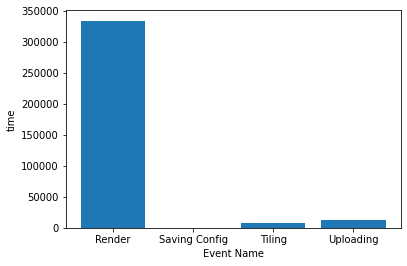

In [23]:
plt.bar(eventtime.eventName,eventtime.total_time,"eventName": )
plt.ylabel('time')
plt.xlabel('Event Name')
plt.rcParams['figure.figsize']=[15,8]

Gpu execution time is majorly dominated by Render as compared to tiling and uploading.

In [ ]:
print(df.describe())


          gpuSerial  powerDrawWatt      gpuTempC   gpuUtilPerc  gpuMemUtilPerc
count  1.048575e+06   1.048575e+06  1.048575e+06  1.048575e+06    1.048575e+06
mean   3.240689e+11   8.932175e+01  4.006577e+01  6.323106e+01    3.347066e+01
std    1.226165e+09   3.965436e+01  3.789499e+00  4.136935e+01    2.294430e+01
min    3.200000e+11   2.255000e+01  2.600000e+01  0.000000e+00    0.000000e+00
25%    3.240000e+11   4.515000e+01  3.800000e+01  0.000000e+00    0.000000e+00
50%    3.240000e+11   9.668000e+01  4.000000e+01  8.900000e+01    4.300000e+01
75%    3.250000e+11   1.213400e+02  4.200000e+01  9.200000e+01    5.100000e+01
max    3.250000e+11   1.970100e+02  5.500000e+01  1.000000e+02    8.300000e+01


0.5012901572626367


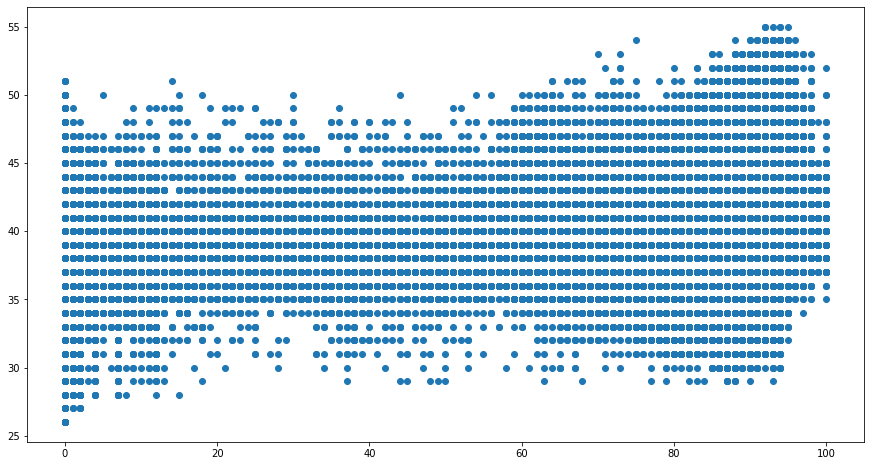

In [28]:
x=df.gpuUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(df.gpuUtilPerc,df.gpuTempC)

0.4886039343543606


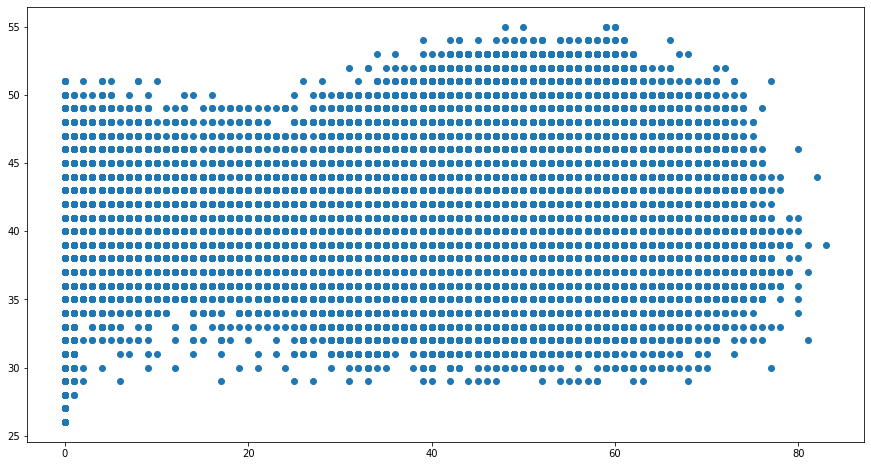

In [29]:
x=df.gpuMemUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

0.5330143179788156


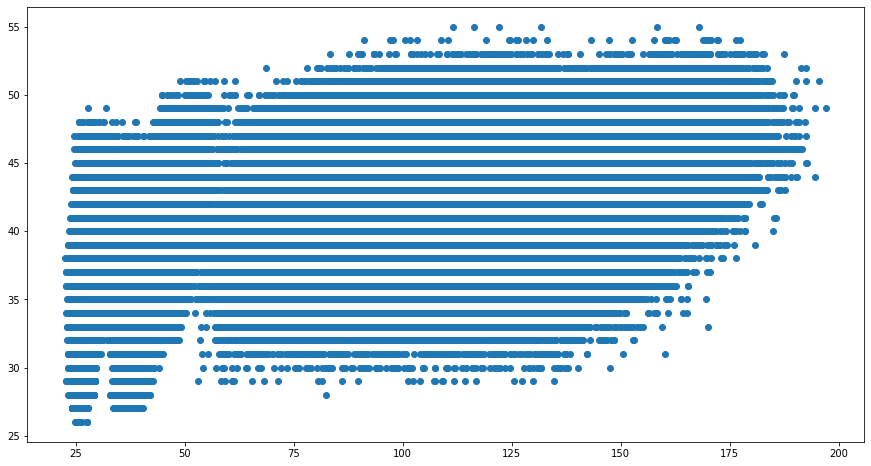

In [30]:
x=df.powerDrawWatt
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

0.8700549872155798


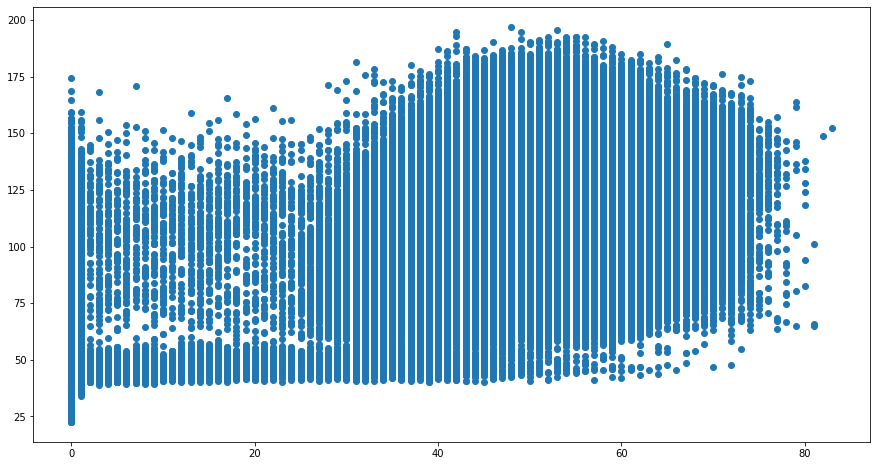

In [31]:
x=df.gpuMemUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.8619284178420462


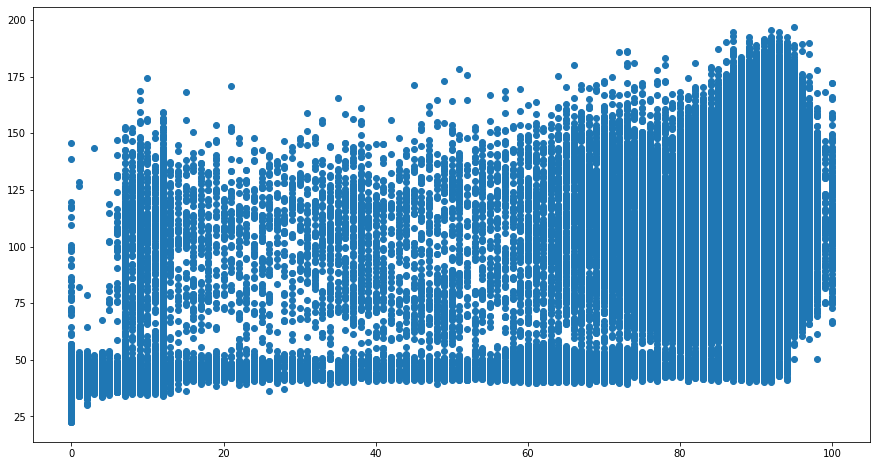

In [32]:
x=df.gpuUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.9662339194538435


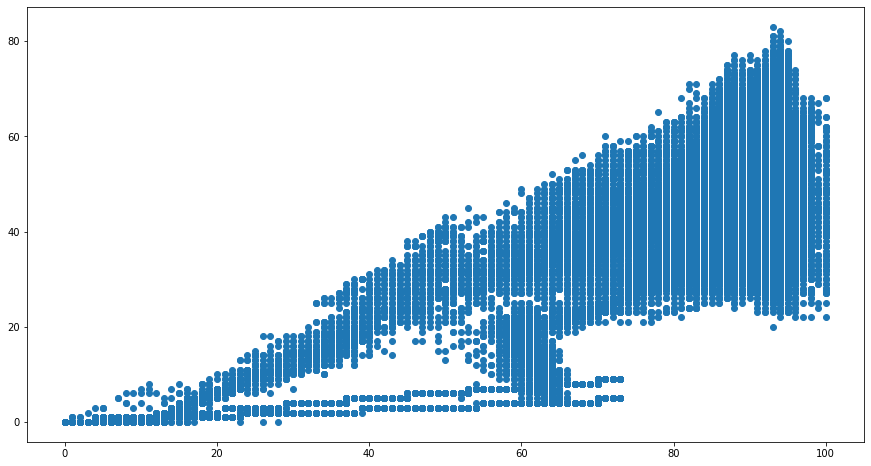

In [33]:
x=df.gpuUtilPerc
y=df.gpuMemUtilPerc
print(x.corr(y))
plt.scatter(x,y)

In [52]:
dftotalrender=ps.sqldf('select * from df3 where eventName="TotalRender" ')
dftotalrender

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,3.240000e+11,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,83ea61ac1ef54f27a3bf7bd0f41ecaa700000C,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c2e827e9-de83-452f-abf2-cc50d4293a3b
1,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,3.240000e+11,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970
2,2018-11-08T08:27:07.808Z,265232c5f6814768aeefa66a7bec6ff600000A,3.240000e+11,GPU-0a470a0d-0f60-58d8-7e32-be9c1b4f828c,47.64,37,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,76fe1add-66f8-4d52-aba3-750d07d9ff85
3,2018-11-08T08:27:13.475Z,265232c5f6814768aeefa66a7bec6ff600000K,3.240000e+11,GPU-5f50560e-c1d9-4cdc-8076-02a03a4c8832,124.88,43,93,52,e7adc42d28814e518e9601ac2329c513000002,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,59f756d6-2e27-4c33-b44e-28aac785da46
4,2018-11-08T08:27:13.460Z,265232c5f6814768aeefa66a7bec6ff600000S,3.240000e+11,GPU-976b3bbd-fdea-ee53-615f-a98f28408299,125.99,44,94,53,4ad946d4435c42dabb5073531ea4f31500000J,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46181,2018-11-08T07:54:12.803Z,5903af3699134795af7eafc605ae5fc7000006,3.250000e+11,GPU-d7733b5a-198f-9ac7-f4c3-14e352f016a0,123.85,37,93,55,6139a35676de44d6b61ec247f0ed865700000Q,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1633ec32-2095-4350-a49c-9bd090cdd655
46182,2018-11-08T07:54:12.491Z,8b6a0eebc87b4cb2b0539e81075191b900000A,3.240000e+11,GPU-e8feba70-8b8d-2cf6-d07e-e391bc0d2064,113.47,40,88,37,db871cd77a544e13bc791a64a0c8ed5000001D,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5a2d0bff-6de0-4074-97d1-384c3072e100
46183,2018-11-08T07:54:12.831Z,5903af3699134795af7eafc605ae5fc700000Z,3.250000e+11,GPU-cad325e7-5d99-a41b-d413-237193881e3c,109.10,42,95,45,4ad946d4435c42dabb5073531ea4f315000006,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,f99f98a0-51a7-4d94-9a6d-8e1f56b9e30c
46184,2018-11-08T07:54:17.964Z,b9a1fa7ae2f74eb68f25f607980f97d700000E,3.250000e+11,GPU-8de116cb-6a17-39e7-2456-f0da76ae4217,86.07,40,91,45,b9a1fa7ae2f74eb68f25f607980f97d700000P,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,33f9f2d6-5c25-4d4d-a6bc-e49cd99480e6


In [55]:
dftotalrender=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from df3merge where eventName="TotalRender" group by eventName')
dftotalrender

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.1229,40.19239,64.796279,34.498449


In [59]:
dfrender=ps.sqldf('select * from df3 where eventName="Render" ')
dfrender

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,3.250000e+11,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
1,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,3.250000e+11,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
2,2018-11-08T08:27:10.359Z,4c72fae95b9147189a0559269a6953ff00000X,3.250000e+11,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc
3,2018-11-08T08:27:10.678Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,3.240000e+11,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0
4,2018-11-08T08:27:10.462Z,95b4ae6d890e4c46986d91d7ac4bf08200000B,3.200000e+11,GPU-c7c7d0c2-88ab-ae92-68f7-7bf529cff6a9,129.40,41,86,39,0d56a730076643d585f77e00d2d8521a00000A,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,dc1a9949-21d5-4098-9c8a-7e21cd4afb4c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45929,2018-11-08T07:54:10.016Z,4ad946d4435c42dabb5073531ea4f315000013,3.250000e+11,GPU-ab4086d0-c200-037d-c26a-ab6d6c26d44b,115.75,39,88,45,4ad946d4435c42dabb5073531ea4f31500000J,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d40fd6e2-1784-4bad-8010-e3698d73dc63
45930,2018-11-08T07:54:11.151Z,e7adc42d28814e518e9601ac2329c513000007,3.250000e+11,GPU-1189a7e2-cccb-2b0f-e256-850c2153f9a3,101.07,40,89,47,cd44f5819eba427a816e7ce648adceb200000V,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e32b5b20-0349-4c8c-aaca-4e3f9191a608
45931,2018-11-08T07:54:09.792Z,e7adc42d28814e518e9601ac2329c51300000I,3.250000e+11,GPU-f6af85fd-e93f-c0c3-0526-cc79034202ed,142.11,44,90,53,4ad946d4435c42dabb5073531ea4f31500000D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe78f346-ad46-4af2-9035-aa629e23160b
45932,2018-11-08T07:54:12.772Z,6139a35676de44d6b61ec247f0ed865700000F,3.250000e+11,GPU-13559820-5378-aa1c-5a1c-c09cb3db9545,45.27,34,0,0,e7adc42d28814e518e9601ac2329c513000005,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e1ab55f8-4aa4-46f3-bea9-cd89028be13b


In [60]:
dfrender=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc) from dfrender group by eventName')
dfrender

,avg(powerDrawWatt),avg(gpuTempC),avg(gpuUtilPerc),avg(gpuMemUtilPerc)
0,91.530251,40.360779,65.252449,34.604998


In [61]:
dfsavingconfig=ps.sqldf('select * from df3 where eventName="Saving Config" ')
dfsavingconfig

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,3.250000e+11,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
1,2018-11-08T08:27:10.678Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,3.240000e+11,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0
2,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,3.240000e+11,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,83ea61ac1ef54f27a3bf7bd0f41ecaa700000C,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c2e827e9-de83-452f-abf2-cc50d4293a3b
3,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,3.240000e+11,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970
4,2018-11-08T08:27:13.784Z,4c72fae95b9147189a0559269a6953ff000019,3.250000e+11,GPU-b9062074-586b-dfcc-c113-d8d71f2586c7,41.35,37,0,0,6139a35676de44d6b61ec247f0ed865700000W,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d23b6035-d201-4b68-ae7a-630f2464112a
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46120,2018-11-08T07:54:10.649Z,04dc4e9647154250beeee51b866b071500000Q,3.240000e+11,GPU-b879a177-04a8-36e1-7e1f-6d1fcf4215d4,27.25,38,0,0,a77ef58b13ad4c01b769dac8409af3f8000003,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d485c5c8-d5b4-426c-9bc0-57f358d4e4ad
46121,2018-11-08T07:54:10.649Z,04dc4e9647154250beeee51b866b071500000Q,3.240000e+11,GPU-b879a177-04a8-36e1-7e1f-6d1fcf4215d4,27.25,38,0,0,dcc19f48bb3445a28338db3a8f002e9c000001,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c1a4733b-8aca-486d-8f83-5aeb54c1d64c
46122,2018-11-08T07:54:09.792Z,e7adc42d28814e518e9601ac2329c51300000I,3.250000e+11,GPU-f6af85fd-e93f-c0c3-0526-cc79034202ed,142.11,44,90,53,4ad946d4435c42dabb5073531ea4f31500000D,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe78f346-ad46-4af2-9035-aa629e23160b
46123,2018-11-08T07:54:12.772Z,6139a35676de44d6b61ec247f0ed865700000F,3.250000e+11,GPU-13559820-5378-aa1c-5a1c-c09cb3db9545,45.27,34,0,0,e7adc42d28814e518e9601ac2329c513000005,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e1ab55f8-4aa4-46f3-bea9-cd89028be13b


In [62]:
dfsavingconfig=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc)	 from dfsavingconfig group by eventName')
dfsavingconfig

,avg(powerDrawWatt),avg(gpuTempC),avg(gpuUtilPerc),avg(gpuMemUtilPerc)
0,90.981746,40.259946,64.78194,34.390526


In [64]:
dftiling=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc)	 from df3 where eventName="Tiling" group by eventName')
dftiling

,avg(powerDrawWatt),avg(gpuTempC),avg(gpuUtilPerc),avg(gpuMemUtilPerc)
0,91.686956,40.458377,65.482672,34.655166


In [65]:
dfuploading=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc  )	 from df3 where eventName="Uploading" group by eventName')
dfuploading

,avg(powerDrawWatt),avg(gpuTempC),avg(gpuUtilPerc),avg(gpuMemUtilPerc)
0,91.77464,40.430827,65.566881,34.705206


In [ ]:
# df3= pd.merge(df1,df2)
# df4=pd.merge(df,df2)
# df5=pd.merge(df3,df4)

In [ ]:
# df3.to_csv('mergetaskapplication.csv')
# df4.to_csv('mergegpuapplication.csv')
# df5.to_csv('mergeall.csv')

In [ ]:
dfrendermergestart=dfrendermerge[(dfrendermerge['eventType']=='START')]
dfrendermergestop=dfrendermerge[(dfrendermerge['eventType'])=='STOP']

In [ ]:
df2

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
...,...,...,...,...,...,...
660395,2018-11-08T08:30:10.296Z,0745914f4de046078517041d70b22fe700000I,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
660396,2018-11-08T08:30:10.325Z,0745914f4de046078517041d70b22fe700000I,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
660397,2018-11-08T08:30:14.081Z,a77ef58b13ad4c01b769dac8409af3f800000H,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099
660398,2018-11-08T08:30:14.127Z,a77ef58b13ad4c01b769dac8409af3f800000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099


In [ ]:
import pandasql as ps 

ps.sqldf("select  eventName , count(taskid) from df2 group by eventName")
ps.sqldf("select eventtype, count(taskid) from df2 group by eventtype")

,eventType,count(taskid)
0,START,320220
1,STOP,319700


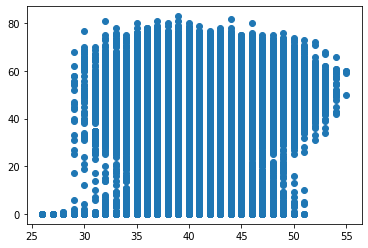

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df.gpuTempC,df.gpuMemUtilPerc)
plt.show()

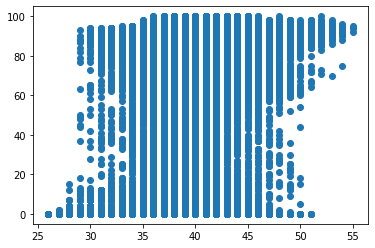

In [ ]:
plt.scatter(df.gpuTempC,df.gpuUtilPerc)
plt.show()

In [ ]:
ps.sqldf("select powerDrawWatt , timestamp from df4 where eventName='Render'")

,powerDrawWatt,timestamp
0,43.41,2018-11-08T08:15:55.618Z
1,45.17,2018-11-08T08:16:33.446Z
2,41.62,2018-11-08T08:08:52.807Z
3,43.65,2018-11-08T08:09:53.771Z
4,43.85,2018-11-08T07:55:15.932Z
5,40.79,2018-11-08T07:43:01.333Z
6,28.22,2018-11-08T07:43:34.342Z
7,28.54,2018-11-08T07:43:41.842Z
8,26.03,2018-11-08T07:59:17.441Z
9,41.45,2018-11-08T07:59:17.206Z


In [ ]:
DF2START= ps.sqldf('select * from df2 where eventType="START"')
DF2START

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
1,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:43:56.239Z,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
3,2018-11-08T07:44:47.555Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
4,2018-11-08T07:47:38.457Z,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba
...,...,...,...,...,...,...
330195,2018-11-08T08:30:10.142Z,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712
330196,2018-11-08T08:30:11.174Z,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c
330197,2018-11-08T08:30:08.759Z,6139a35676de44d6b61ec247f0ed865700001D,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf
330198,2018-11-08T08:30:09.642Z,0d56a730076643d585f77e00d2d8521a00000D,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6


In [ ]:
DF2STOP=ps.sqldf('select * from df2 where eventType="STOP"')
DF2STOP

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:43:56.239Z,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
4,2018-11-08T07:43:57.223Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
...,...,...,...,...,...,...
330195,2018-11-08T08:30:10.296Z,0745914f4de046078517041d70b22fe700000I,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
330196,2018-11-08T08:30:10.325Z,0745914f4de046078517041d70b22fe700000I,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8261c0ff-03d6-48b3-a50f-da41cb3291fd
330197,2018-11-08T08:30:14.081Z,a77ef58b13ad4c01b769dac8409af3f800000H,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099
330198,2018-11-08T08:30:14.127Z,a77ef58b13ad4c01b769dac8409af3f800000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ce97e3e9-494a-43a7-aa85-edd2db4cf099


In [ ]:
from datetime import datetime
for i in range(330200):
  DF2START.timestamp[i]= datetime.strptime(DF2START.timestamp[i],'%Y-%m-%dT%H::%M::%S.%f')

ValueError: ignored

In [ ]:
import datetime
DF2START['timestamp']=pd.to_datetime(DF2START['timestamp'])
DF2STOP['timestamp']=pd.to_datetime(DF2STOP['timestamp'])

In [ ]:
DF2START['Common1']=DF2START['taskId']+DF2START['eventName']

In [ ]:
DF2STOP['Common2']=DF2STOP['taskId']+DF2STOP['eventName']

In [ ]:
DF2DIFF

,timestamp,hostname,eventName,eventType,jobId,taskId
0,33.921,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
1,0.000,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,42.282,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
3,51.316,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
4,221.234,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba
...,...,...,...,...,...,...
330195,-0.154,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712
330196,0.849,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c
330197,-5.322,6139a35676de44d6b61ec247f0ed865700001D,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf
330198,-4.485,0d56a730076643d585f77e00d2d8521a00000D,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6


In [ ]:
DF2START

,timestamp,hostname,eventName,eventType,jobId,taskId
0,1.541663,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
1,1.541663,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,1.541663,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
3,1.541663,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
4,1.541663,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba
...,...,...,...,...,...,...
47722,1.541665,cd44f5819eba427a816e7ce648adceb200000P,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ad84978a-31e3-4171-a40b-956ecea99d6b
47723,1.541665,6139a35676de44d6b61ec247f0ed8657000018,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,bb670344-dd9a-4b4f-a73e-346ec441edce
47724,1.541665,b9a1fa7ae2f74eb68f25f607980f97d700000H,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8385ab00-e508-4883-9775-f477c845de9e
47725,1.541665,2ecb9d8d51bc457aac88073f6da0546100000U,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ff28b0f5-0396-476f-ac1a-8cb9782b3bf0


In [ ]:
import datetime
ps.sqldf('select DF2START.timestamp,DF2STOP.timestamp from DF2START, DF2STOP ')
#DF2DIFF.timestamp=DF2START.timestamp-DF2STOP.timestamp
#WHERE DF2START.taskId=DF2STOP.taskId and DF2START.eventName=DF2STOP.eventName

In [ ]:
ps.sqldf('select DF2STOP.timestamp-DF2START.timestamp from DF2START,DF2STOP ')

In [ ]:
DF2START['timestamp']-DF2STOP['timestamp']

TypeError: ignored

In [ ]:
newdf=pd.merge(DF2START,DF2STOP,how='left', left_on=['Common1'],right_on =['Common2'] )

In [ ]:
newdf

,timestamp_x,hostname_x,eventName_x,eventType_x,jobId_x,taskId_x,Common1,timestamp_y,hostname_y,eventName_y,eventType_y,jobId_y,taskId_y,Common2
0,2018-11-08 07:42:29.842000+00:00,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dSaving Config,1970-01-01 00:00:01.541662949,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dSaving Config
1,2018-11-08 07:42:29.845000+00:00,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dRender,1970-01-01 00:00:01.541662990,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dRender
2,2018-11-08 07:43:56.239000+00:00,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,3dd4840c-47f2-4dcc-a775-df2ef6498d71Uploading,1970-01-01 00:00:01.541663037,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,3dd4840c-47f2-4dcc-a775-df2ef6498d71Uploading
3,2018-11-08 07:44:47.555000+00:00,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,c9e249d8-52ed-40c6-8713-b5cbf02ea87eSaving Config,1970-01-01 00:00:01.541663087,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,c9e249d8-52ed-40c6-8713-b5cbf02ea87eSaving Config
4,2018-11-08 07:47:38.457000+00:00,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfbaUploading,1970-01-01 00:00:01.541663259,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfbaUploading
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332665,2018-11-08 08:30:10.142000+00:00,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712,fe1e7f4d-a52b-4899-985c-7ac3940ab712Tiling,1970-01-01 00:00:01.541665811,04dc4e9647154250beeee51b866b0715000004,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712,fe1e7f4d-a52b-4899-985c-7ac3940ab712Tiling
332666,2018-11-08 08:30:11.174000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c,120e5f6f-67a7-4973-b431-026f1a68400cUploading,1970-01-01 00:00:01.541665812,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c,120e5f6f-67a7-4973-b431-026f1a68400cUploading
332667,2018-11-08 08:30:08.759000+00:00,6139a35676de44d6b61ec247f0ed865700001D,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf,30caa975-249a-445d-a6c0-61fa38d4c4bfTiling,1970-01-01 00:00:01.541665809,6139a35676de44d6b61ec247f0ed865700001D,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf,30caa975-249a-445d-a6c0-61fa38d4c4bfTiling
332668,2018-11-08 08:30:09.642000+00:00,0d56a730076643d585f77e00d2d8521a00000D,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6Uploading,1970-01-01 00:00:01.541665810,0d56a730076643d585f77e00d2d8521a00000D,U

In [ ]:
newdf['timedifference']=newdf['timestamp_y']-newdf['timestamp_x']

TypeError: ignored

In [ ]:
newdf

,timestamp_x,hostname_x,eventName_x,eventType_x,jobId_x,taskId_x,Common1,timestamp_y,hostname_y,eventName_y,eventType_y,jobId_y,taskId_y,Common2,timedifference
0,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dSaving Config,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dSaving Config,0.003
1,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dRender,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,20fb9fcf-a927-4a4b-a64c-70258b66b42dRender,41.120
2,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,3dd4840c-47f2-4dcc-a775-df2ef6498d71Uploading,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,3dd4840c-47f2-4dcc-a775-df2ef6498d71Uploading,1.006
3,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,c9e249d8-52ed-40c6-8713-b5cbf02ea87eSaving Config,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,c9e249d8-52ed-40c6-8713-b5cbf02ea87eSaving Config,0.002
4,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfbaUploading,1.541663e+09,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfbaUploading,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332665,1.541666e+09,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712,fe1e7f4d-a52b-4899-985c-7ac3940ab712Tiling,1.541666e+09,04dc4e9647154250beeee51b866b0715000004,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712,fe1e7f4d-a52b-4899-985c-7ac3940ab712Tiling,1.059
332666,1.541666e+09,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c,120e5f6f-67a7-4973-b431-026f1a68400cUploading,1.541666e+09,b9a1fa7ae2f74eb68f25f607980f97d7000005,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,120e5f6f-67a7-4973-b431-026f1a68400c,120e5f6f-67a7-4973-b431-026f1a68400cUploading,0.900
332667,1.541666e+09,6139a35676de44d6b61ec247f0ed865700001D,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf,30caa975-249a-445d-a6c0-61fa38d4c4bfTiling,1.541666e+09,6139a35676de44d6b61ec247f0ed865700001D,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,30caa975-249a-445d-a6c0-61fa38d4c4bf,30caa975-249a-445d-a6c0-61fa38d4c4bfTiling,0.971
332668,1.541666e+09,0d56a730076643d585f77e00d2d8521a00000D,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6Uploading,1.541666e+09,0d56a730076643d585f77e00d2d8521a00000D,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6,423b8511-cb2e-4aa4-bb5c-85ca4a2b7ac6Uploading,0.972


In [ ]:
# newdf.timedifference=newdf['timedifference'].to_seconds()
newdf['timedifference']=pd.to_datetime(newdf['timedifference']).apply(lambda x: x.to_seconds())

AttributeError: ignored

In [ ]:
dfst=pd.read_csv('/content/mergedstartstop.csv')
dfst

,Unnamed: 0,timestamp.x.timestamp,timestamp.x.hostname,timestamp.x.eventName,timestamp.x.eventType,timestamp.x.jobId,timestamp.x.taskId,hostname.x,eventName.x,eventType.x,jobId.x,taskId.x,combinestart,timestamp.y.timestamp,timestamp.y.hostname,timestamp.y.eventName,timestamp.y.eventType,timestamp.y.jobId,timestamp.y.taskId,hostname.y,eventName.y,eventType.y,jobId.y,taskId.y
0,1,2018-11-08 07:42:29,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,Saving Config 20fb9fcf-a927-4a4b-a64c-70258b66...,2018-11-08 07:42:29,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
1,2,2018-11-08 07:42:29,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,Render 20fb9fcf-a927-4a4b-a64c-70258b66b42d,2018-11-08 07:43:10,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,3,2018-11-08 07:43:56,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,Uploading 3dd4840c-47f2-4dcc-a775-df2ef6498d71,2018-11-08 07:43:57,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
3,4,2018-11-08 07:44:47,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,Saving Config c9e249d8-52ed-40c6-8713-b5cbf02e...,2018-11-08 07:44:47,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
4,5,2018-11-08 07:47:38,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,Uploading c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,2018-11-08 07:47:39,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332665,332666,2018-11-08 08:30:10,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fe1e7f4d-a52b-4899-985c-7ac3940ab712,04dc4e9647154250beeee51b866b0715000004,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7

In [ ]:

# dfst['timediff']=dfst['timestamp.x.timestamp']-dfst['timestamp.y.timestamp']
# datetime.strptime(dfst['timestamp.x.timestamp'],' %Y-%m-%dT%H::%M::%S.%f')
from datetime import datetime
for i in range(332670):
  dfst.timestamp.x.timestamp[i]= datetime.strptime(dfst.timestamp.x.timestamp[i],'%Y-%m-%dT%H::%M::%S.%f')

AttributeError: ignored

In [ ]:
df3 = pd.merge(df, df2, on = ["hostname"])